## Vision Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, label_file, transform=None):
        self.img_dir = img_dir
        self.labels = pd.read_csv(label_file)
        self.transform = transform
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.labels.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
class ManualAttentionHeads(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.head_dim = emb_dim // num_heads
        self.num_heads = num_heads
        self.q_proj = nn.Linear(emb_dim, emb_dim)
        self.k_proj = nn.Linear(emb_dim, emb_dim)
        self.v_proj = nn.Linear(emb_dim, emb_dim)
        self.out_proj = nn.Linear(emb_dim, emb_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = (attn_weights @ v).transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        return self.out_proj(attn_out), attn_weights

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_dim)
        self.attn = ManualAttentionHeads(emb_dim, num_heads)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        attn_out, attn_weights = self.attn(self.norm1(x))
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x, attn_weights

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, emb_dim=128, depth=6, num_heads=4, mlp_dim=128, dropout=0.1):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_chans, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, emb_dim))
        self.blocks = nn.ModuleList([TransformerBlock(emb_dim, num_heads, mlp_dim, dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, num_classes)


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        attn_weights = []
        for blk in self.blocks:
            x, weights = blk(x)
            attn_weights.append(weights)
        x = self.norm(x)
        return self.head(x[:, 0]), attn_weights

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = VisionTransformer().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=0.001)


In [ ]:
for epoch in range(15):
    vit_model.train()
    train_correct = 0
    train_total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = vit_model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
    print(f'Epoch {epoch+1} | Train Acc: {100.*train_correct/train_total:.4f}%')

Epoch 1 | Train Acc: 36.0820%
Epoch 2 | Train Acc: 50.7580%
Epoch 3 | Train Acc: 56.7840%
Epoch 4 | Train Acc: 61.2080%
Epoch 5 | Train Acc: 63.5080%
Epoch 6 | Train Acc: 66.1440%
Epoch 7 | Train Acc: 67.9380%
Epoch 8 | Train Acc: 69.2400%
Epoch 9 | Train Acc: 70.8800%
Epoch 10 | Train Acc: 72.2340%
Epoch 11 | Train Acc: 73.8380%
Epoch 12 | Train Acc: 75.1920%
Epoch 13 | Train Acc: 76.8660%
Epoch 14 | Train Acc: 77.9540%
Epoch 15 | Train Acc: 79.4840%


In [ ]:
vit_model.eval()
test_images, test_labels = next(iter(val_loader))
with torch.no_grad():
    _, attention_weights = vit_model(test_images.to(device))

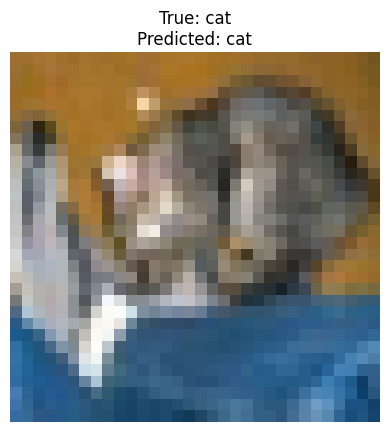

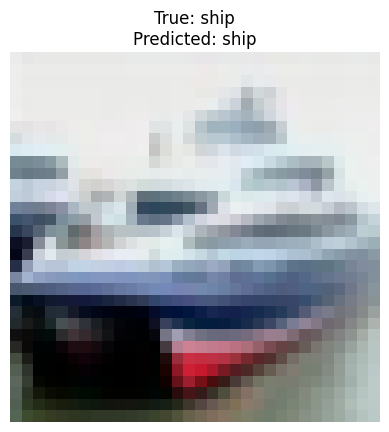

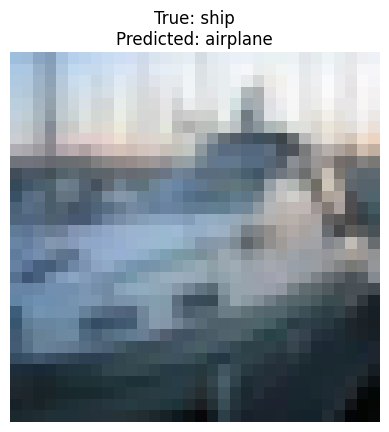

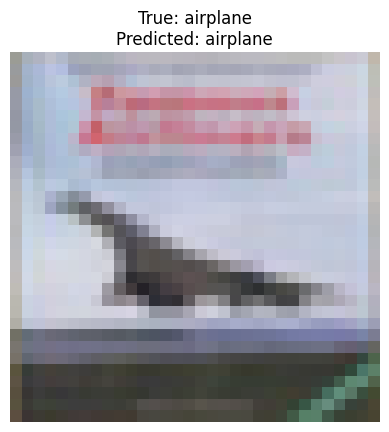

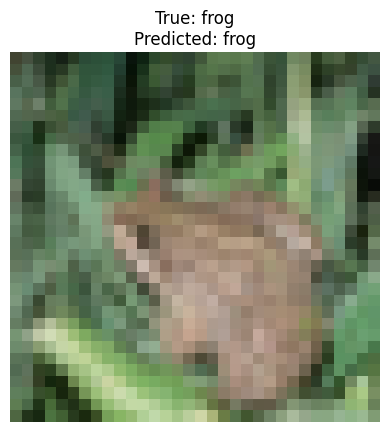

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def predict_and_show(model, dataset, index, device):
    model.eval()
    image, true_label = dataset[index]
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs, _ = model(image_tensor)

    predicted_label = torch.argmax(outputs, dim=1).item()

    image = image.numpy().transpose(1, 2, 0)
    image = image * np.array([0.247, 0.243, 0.261]) + np.array([0.4914, 0.4822, 0.4465])
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}")
    plt.axis('off')
    plt.show()

for i in range(5):
    predict_and_show(vit_model, test_dataset, i, device)

In [ ]:
def show_attention_maps(img, attns):
    img = img.numpy().transpose(1,2,0)
    img = img * np.array([0.247, 0.243, 0.261]) + np.array([0.4914, 0.4822, 0.4465])
    plt.figure(figsize=(4,4))
    plt.imshow(np.clip(img, 0, 1))
    for layer_idx, attn in enumerate(attns):
        plt.figure(figsize=(4,4))
        attention_map = attn[0, 0, 0, 1:].reshape(8,8).cpu()
        plt.imshow(attention_map, cmap='viridis')
        plt.title(f'Layer {layer_idx+1} Attention')
        plt.show()

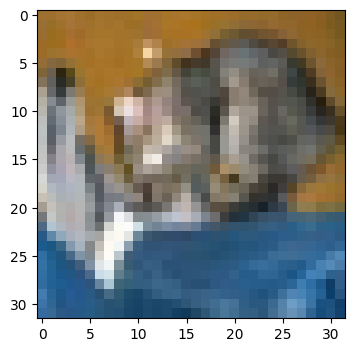

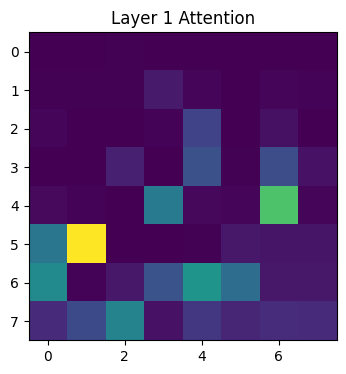

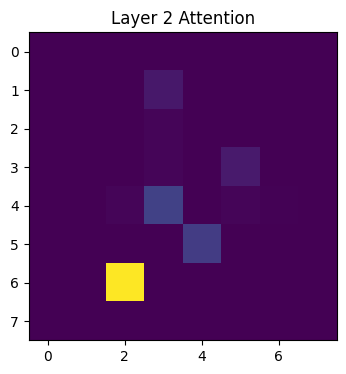

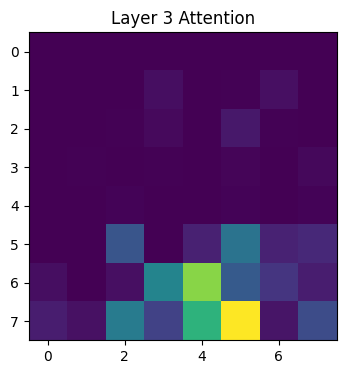

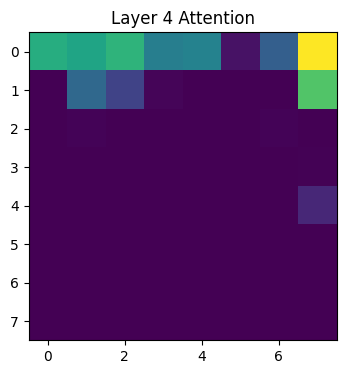

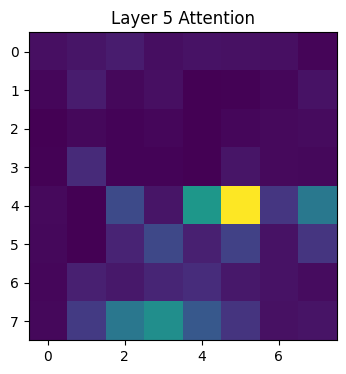

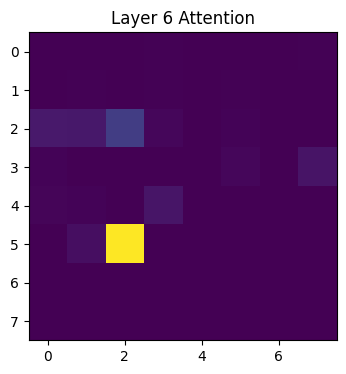

In [ ]:
show_attention_maps(test_images[0], attention_weights)